# Least Squares for Linear Systems

As explained in *Section 04-Regression Line and Least Squares*, the Least Squares methodology is used to estimate the parameters of a fitting curve that minimize the differences between the measurements and the modeled values. This kind of approach is widely used in statistics for static datasets (i.e., the measurements $\mathbf{y}$ are not time dependent); in this Section we'll discuss how to implement the Least Squares approach for dynamic systems instead.



## Least Squares Estimation

Suppose we have have a set of discrete measurements $y_i = y \left ( t_i \right )$ for $i=1,..,m$. These are assumed to be a linear function of a set of parameters with random measurement $e_{i}$ noise added. Each measurement can be expressed as 

#### $$  y_{i}=\textbf{h}_i\textbf{x} \left ( t_i \right )+ e_{i}$$

,where:
- $\textbf{x}$ is the **state vector** of dimension $n$ (the parameter set to evaluate)
- $\textbf{h}_i$ is a 1 x *n* vector that defines how the parameters in $\textbf{x}$ map to the measurements $y_{i}$
- $e_{i}$ is the **measurement error** assumed to be zero mean with a fixed variance.

For convenience, all the measurements are often collected into a column vector to give the following vector form:

#### $$\begin{bmatrix}
y_{1} \\
y_{2} \\
... \\
y_{m}
\end{bmatrix} = \begin{bmatrix}
\textbf{h}_1 \\
\textbf{h}_2 \\
... \\
\textbf{h}_m\end{bmatrix}\textbf{x} + \begin{bmatrix}
e_1 \\
e_2 \\
... \\
e_m\end{bmatrix}$$

or 

#### $$ \textbf{y}=\textbf{H}\textbf{x}+\mathbf{e}$$

, where $\textbf{H}$ is a $m$ x $n$ matrix with $m$ = number of measurements and $n$ in the number of states.



To find the value of the unknown $n$ states (in this case $n$ = 2, defined as $s_{0}$ and $V$) we'll use the least squares approach. The **normal equation** is:

### $$ \hat{\textbf{x}}=\left ( \textbf{H}^T \textbf{H} \right )^{-1} \textbf{H}^T \textbf{y} $$

, where $ \hat{\textbf{x}} $ is the state vector that better fits the measurements data.





### Train Motion Example

Let's take the motion of a train who travels at constant velocity along a straight route as an example of dynamic system. The position of the train is measured using a radar placed at the origin of the reference system which the radar measures a noisy time-varying distance (each measure brings an unknow error with it). 

<center><img src="Images/train.png" alt="Drawing" style="width: 600px;"/><center>

In [1]:
from estimation import *
df = pd.read_csv('Data/radarTrain.csv')
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Time,0.000000,1.00000,2.000000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000
Range,50.796399,55.32244,59.010941,62.29532,65.387984,68.966864,74.739553,77.433599,81.900603,86.059852,91.342493,94.122402,98.936087,103.210051,105.774418,109.288249


Our goal is to estimate the  position of the train respect to the radar site and its velocity at any time $t$, so this problem is characterized by the following:
- **Observations**: range measurements (between the radar and the train)
- **Knowns**: train velocity (assumed to be deterministic)
- **Unknowns**: initial position and velocity of the train

The **time evolution model** is 

#### $$ x\left ( t \right )=x_0+ \dot x t $$
, where $x_0$ is the intial distance of the train respect to the origin of the reference system. Follows that the system under consideration is **linear** and **time invariant**.


We define the **state** of the system as the 2x1 ($n$=2) column vector:

#### $$ \mathbf{x}  =\begin{bmatrix}
x  &  \dot x \\
\end{bmatrix}^T$$

We want to estimate the state at $t=0$:

#### $$ x\left ( 0 \right )  =\begin{bmatrix}
x_0  &  v_0 \\
\end{bmatrix}^T$$

Since the radar generates distance measurement whcih directly relate to the position of the train, the **measurement model** can be written as

#### $$ y_t = \mathbf{h} \mathbf{x} = \begin{bmatrix}
1 &  t\\
\end{bmatrix}\begin{bmatrix}
x_0 \\ v_0
\end{bmatrix}$$

and each measure $y_i$ can be written as

#### $$y_i  = \begin{bmatrix}
1 &  t_i\\
\end{bmatrix}\begin{bmatrix}
x_0 \\ v_0
\end{bmatrix} + e$$

We here see how $\mathbf{h}$ maps the state to the measurements and is a linear funtion of time $t$.

For the above example we have 

$$\textbf{x} = \left [ \begin{matrix}
x_0 &  v_0\\
\end{matrix} \right ], \quad 
\textbf{H} =\begin{bmatrix}
1 &  0\\
1 &  1\\
... & ... \\
1 &  15\\
\end{bmatrix}, \quad 
\textbf{y}= \begin{bmatrix}
50.796399 \\
55.322440 \\
...\\
109.288249\\
\end{bmatrix}$$ 

In [2]:
dataArray = df.to_numpy()
times = dataArray[:,0]
measures = dataArray[:,1]
m = len(times)
 
# Define the H matrix
H = np.array([np.ones(len(times)),times.flatten()]).T
 
# define the y vector
y = measures.T

# implement the normal equation
F = np.linalg.inv(H.T.dot(H)).dot(H.T).dot(y)
x0  = F[0]
v0  = F[1]
print('x0 estimate  = ' + str(x0) + ' m') 
print('v0 estimate  = ' + str(v0) + ' m/sec') 

x0 estimate  = 50.500039282279445 m
v0 estimate  = 3.971555220029409 m/sec


We estimated the state at $t=0$. What about estimating it at $t  \neq 0$? In this case, the trick is about to translate the time axis to the epoch we're interested in. Assuming $t_{ref}$ is the epoch of interest, the $t$ values in the  $\textbf{H}$ matrix have to be translated accordingly:

#### $$\textbf{H} =\begin{bmatrix}
1 &  0 - t_{ref}\\
1 &  1 - t_{ref}\\
... & ... \\
1 &  15 - t_{ref}\\
\end{bmatrix}$$

The result will be 
#### $$ x\left ( t_{ref} \right )  =\begin{bmatrix}
x_{t_{ref}}  &  v_{t_{ref}} \\
\end{bmatrix}^T$$

In [3]:
################# Input ########################
refTime = 8 # reference time (sec)
################################################

# Define the new H matrix considering the new epoch
H = np.array([np.ones(len(times)),times.flatten() - refTime]).T
 
# define the y vector
y = measures.T

# implement the normal equation
F = np.linalg.inv(H.T.dot(H)).dot(H.T).dot(y)
x = F[0]
v = F[1]
print('x_t estimate  = ' + str(x) + ' m') 
print('v_t estimate  = ' + str(v) + ' m/sec') 

x_t estimate  = 82.27248104251471 m
v_t estimate  = 3.971555220029411 m/sec


## Residuals and Root Mean Square Error
We now have found the values of the state parameters that best fit the measurements data with the provided dynamic model. At this point we can calculate the corresponding **residuals**, i.e. the difference between measured values and model's values:

#### $$r_i = y_i - \hat{y}_i$$

The **Root Mean Square Error (RMSE)** is a measure of absolute error between the observed and modeled values. The smaller an RMSE value, the closer predicted and observed values are. It is defined as:

#### $$RMSE = \sqrt{\frac{1}{m} \sum_{i=1}^{m} \left ( y_{i} - \hat{y}_i \right )^{2}} $$

This definition the RMSE is quite similar to the definition of standard deviation:

#### $$\sigma = \sqrt{\frac{1}{m} \sum_{i=1}^{m} \left ( y_{i} - \mu \right )^{2}} $$

The main difference between the two is whether we are considering the deviation of the estimator of interest from the 'true' parameter (this is the mean squared error), or the deviation of the estimator from its mean (this is the standard deviation). Consequently, we can see that when the bias of the estimator is zero, the standard deviation and the RMSE are equal. In other words, the standard deviation just measures the dispersion of the values; the RMSE indicates how different the values of the estimator and the actual values of the parameters are. 

From the values of the residuals we can also estimate their standard deviation, estimating the performances of the tracking device:

## A Posteriori Errors Estimation

The normal equation also allows to evaluate the uncertainties on the state estimates. Recalling that

### $$ \hat{\textbf{x}}=\left ( \textbf{H}^T \textbf{H} \right )^{-1} \textbf{H}^T \textbf{y} $$

we define the **a posteriori state error covariance** $\textbf{P}$ as:

### $$\textbf{P} = (\textbf{H}^T\textbf{H})^{-1}$$

Being $n$ the number of states to estimate, $\textbf{P}$ is a $n$x$n$ symmetric matrix, where:
- The diagonal elements $P_{ii}$ are the *a posteriori* variances $\sigma_i^2$ of each state variable ($i=1,..,n)$; their square roots are the represent the standard deviations of each of the state variable estimate, that tell us the uncertainty around each estimate
- The off-diagonal elements $P_{ij}$ are the covariances of the states $i$ and $j$. From the $P_{ij}$ values we can derive the correlation coefficient, which tells us how the different state variables are related to each other.

**Given $m$ the number of measurements, the *a posteriori* $\sigma$ will decrease approximately as $\frac {1}{\sqrt{m}}$**


## Weighted Least Squares
When we have more than a single measurement device we need to take into account the different performances (e.g., the standard deviations) in order to give more importance to the measurements which have smaller errors. In this case we can introduce a **weight matrix** $\mathbf{W}$ through which we can apply the specific 'weight' to each measurement depending on the performances of the related tracking instrument.

 Defined $\sigma_1, \sigma_2,...,\sigma_m$ the standard deviations of $m$ measurements (obtained from different tracking devices), the weight matrix is a diagonal $m$ x $m$ matrix defined as follow:

 $$W_{ii} = \frac{1}{\sigma_{i}^2}, W_{ij} = 0 \quad i,j=1...m$$

The higher the standard deviation $\sigma$ of the tracker, the lower the importance given to any measurements coming from that tracker.


In this case the **normal equation** is:

### $$ \hat{\textbf{x}}=\left ( \textbf{H}^T W \textbf{H} \right )^{-1} \textbf{H}^T W \textbf{y} $$


and the a posteriori state error covariance $\textbf{P}$ is:

### $$\textbf{P} = (\textbf{H}^T\textbf{W}\textbf{H})^{-1}$$

## Sensor Fusion Example

In general, sensor fusion is the process of combining sensor data from different sources so that the resulting information has less uncertainty than would be possible if these sources were used individually.

In the example below there are two trackers taking measurements of a train moving at constant speed. The parameters of the time evolution model, the number of measurements for each tracker and the stochastic models of the trackers are provided as input data. Here we assume unbiased trackers (the constant offset error is equal to zero). 

The effect of each tracker on the combined solution is weighted accordingly with their uncertainty: the bigger the sigma, the lower the weight in the combined solution.


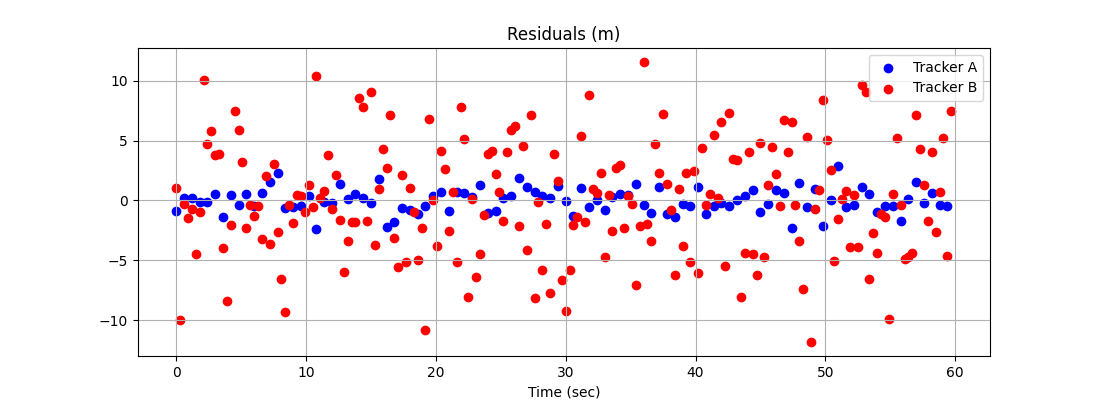

--------------------- State estimation from Tracker A ---------------------------
Estimated x0 = 300.27914534682657 - 0.19949431018948843 m 1-sigma
Estimated v0 = 3.9932850179306465 - 0.005861499570444418 m/sec 1-sigma
 
--------------------- State estimation from Tracker B ---------------------------
Estimated x0 = 300.25035221504004 - 0.7062178973892995 m 1-sigma
Estimated v0 = 4.009837740878608 - 0.02056672975315024 m/sec 1-sigma
 
------------------ State estimation from sensor fusion  -------------------------
Estimated x0 = 300.2770175478454 - 0.19198158164884035 m 1-sigma
Estimated v0 = 3.9945285029690174 - 0.005637035898105367 m/sec 1-sigma


In [4]:
from estimation import *
%matplotlib widget
################## input data ######################
### time evolution model ####
x0 = 300         # m
v0 = 4          # m/sec
interval = 60   #sec - the duration of the simulation

### Tracker A ###
nMeasurements_A = 100
sigma_A = 1     # m - standard deviation       

### Tracker B ###
nMeasurements_B = 200
sigma_B = 5     # m - standard deviation  
####################################################

TrainTracking(x0, v0, interval, nMeasurements_A, sigma_A, nMeasurements_B, sigma_B)